# Imports
***

In [1]:
import pandas as pd 
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import os
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
print(__version__)# requires version >= 1.9.0
import plotly
import plotly.graph_objs as go
from datetime import datetime
plotly.offline.init_notebook_mode(connected=True)
import os
from keras.models import model_from_json
from sklearn.externals import joblib
plt.rcParams["figure.figsize"] = (15,7)

Using TensorFlow backend.


3.3.0


# Helper functions
***

Assumed time period is hourly on full hours.

In [2]:
def read_electricity_p(appliances = None, 
                       limit = None, 
                       filename = 'Electricity_P.csv'):
    
    """Reads Electricity_p dataset

    Args:
        appliances: devices to read.
        limit: limit the number of rows to read.
        rel_file_path: relative path to file to read.

    Returns:
        in-memory read pandas dataframe along with the appliances 
    """
    
    # NOTE: data will be provided in google cloud storage
    filename = os.path.dirname(os.path.dirname(os.getcwd()).replace(' ','\ ')) + "/src/model/data/" + filename
    
    # define appliance which shall be displayed
    if appliances is None and limit is None:
        electricity_data = pd.read_csv(filename,sep=",")
    elif appliances is None and limit is not None:
        electricity_data = pd.read_csv(filename,sep=",", nrows = limit)
    elif appliances is not None and limit is None:
        electricity_data = pd.read_csv(filename,sep=",", usecols=(appliances+['UNIX_TS']))
    else:
        electricity_data = pd.read_csv(filename,sep=",",nrows = limit, usecols=(appliances+['UNIX_TS']))

    # conert date column into plotly-interpretable format
    electricity_data['UNIX_TS'] = pd.to_datetime(electricity_data['UNIX_TS'],unit='s').astype(datetime)
    
    # set index to date
    #electricity_data.set_index('UNIX_TS')

    # aggregate on an hour basis
    electricity_data = electricity_data \
        .groupby(electricity_data.UNIX_TS.map(lambda x: x.strftime('%Y-%m-%d %H'))) \
        .mean()

    appliances = electricity_data.columns.values
    return electricity_data, appliances


def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


'''# invert differenced value
def inverse_difference(history, differenced):
    # invert transform
    inverted = list()
    for i in range(len(differenced)):
        value = differenced[i] + history[-(len(history)-i)]
        inverted.append(value)
    inverted = pd.Series(inverted)
    return inverted'''

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scale
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    series_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, series_scaled, test_scaled
 
'''# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]'''


def invert_scale(scaler, predictions):
    array = [[a[0]] + [b[0]] for a, b in zip(predictions, predictions)]
    array = np.array(array)
    #array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted#[:,-1]

 
def invert_normalize(scaler, series_raw, series_predictions_normalized):
    series_predictions_scaled = invert_scale(scaler, series_predictions_normalized)
    #print(series_predictions_scaled[0:10])
    # invert transform
    tmp = list()
    for i in range(len(series_predictions_scaled)):
        #if i < 10:
        #    print("step " + str(i))
        #    print("series_predictions[i]" + str(series_predictions_scaled[i]))
        #    print(series_raw[-(len(series_raw)-i)])
        value = inverse_difference(series_raw, series_predictions_scaled[i], len(series_raw)-i)
        #if i < 10:
        #    print(value)
        tmp.append(value)
    series_predictions = pd.Series(tmp)
    series_predictions = [x[0]  for x in series_predictions]
    return series_predictions


def compute_rmse(raw, prediction):
    if len(raw) != len(prediction):
        raise ValueError("raw series and predicition series do not have same input length!")
    rmse = sqrt(mean_squared_error(raw, prediction))
    return rmse


def print_series(raw, prediction, ind_start = 0, ind_end = None, legend_1 = 'raw series', legend_2 = 'prediction series'):
    if ind_end is None:
        ind_end = max(len(raw),len(prediction))
    plt.plot(list(raw)[ind_start:ind_end],'o-')
    plt.plot(list(prediction)[ind_start:ind_end],'o-')
    plt.gca().legend((legend_1,legend_2), prop={'size': 18})
    plt.show()
    
    
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons, raw_normalized, scaler):
    
    # create input features and corresponding output
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])

    # initialize train and test error histories
    train_err_hist = []
    test_err_hist = []
    
    # reeshape normalized input to get model prediction in original scale
    raw_normalized_reshaped = raw_normalized[:, 0].reshape(len(raw_normalized), 1, 1)
    
    # build model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
        
        raw_normalized_predictions = model.predict(raw_normalized_reshaped, batch_size=1)
        model_prediction = invert_normalize(scaler, raw_values, raw_normalized_predictions)
        
        train_err_hist.append(compute_rmse(raw_values[1:][:n_train], model_prediction[:n_train]))
        test_err_hist.append(compute_rmse(raw_values[1:][n_train:n_train+n_test], model_prediction[n_train:n_train+n_test]))
        
    return model, train_err_hist, test_err_hist


def save_model(lstm_model, model_name):

    # serialize model to JSON
    lstm_model_json = lstm_model.to_json()
    home_dir = os.path.dirname(os.path.dirname(os.getcwd()).replace(' ','\ '))+ "/src/model/models/"
    with open(home_dir+model_name +".json" , "w") as json_file:
        json_file.write(lstm_model_json)

    # serialize weights to HDF5
    lstm_model.save_weights(home_dir+model_name+".h5")

    
def save_scaler(scaler, scaler_name):
    home_dir = os.path.dirname(os.path.dirname(os.getcwd()).replace(' ','\ '))+ "/src/model/data/"
    scaler_filename = home_dir +scaler_name
    joblib.dump(scaler, scaler_filename) 
    
    
def save_ndarray(ndarray, ndarray_name):
    home_dir = os.path.dirname(os.path.dirname(os.getcwd()).replace(' ','\ '))+ "/src/model/data/"
    ndarray_filename = home_dir +ndarray_name + ".npy"
    np.save(ndarray_filename, ndarray) 
    

def load_model(model_name):
    home_dir = os.path.dirname(os.path.dirname(os.getcwd()).replace(' ','\ '))+ "/src/model/models/"

    # load json and create model
    json_file = open(home_dir+model_name+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    lstm_model = model_from_json(loaded_model_json)

    # load weights into new model
    lstm_model.load_weights(home_dir+model_name+".h5")
    print("Loaded model from disk")
    return lstm_model

    
def load_scaler(scaler_name):
    # load scaler model
    home_dir =os.path.dirname(os.path.dirname(os.getcwd()).replace(' ','\ '))+ "/src/model/data/"
    scaler_filename = home_dir+scaler_name
    scaler = joblib.load(scaler_filename) 
    return scaler


def load_ndarray(ndarray_name):
    home_dir = os.path.dirname(os.path.dirname(os.getcwd()).replace(' ','\ '))+ "/src/model/data/"
    ndarray_filename = home_dir +ndarray_name+".npy"
    ndarray = np.load(ndarray_filename) 
    return ndarray

# Forecasting
***

## 0. Data Preparation

In [3]:
APPLIANCE = 'EQE'
VERSION = '1'

# read data
electricity_data, appliances= read_electricity_p(appliances = [APPLIANCE])
raw_values = electricity_data.values

# form difference
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
test_portion = 0.1
n = len(supervised_values)
train, test = supervised_values[0:-int(n*test_portion)], supervised_values[-int(n*test_portion):]
print('Train shape:  {}\nTest shape:  {}'.format(train.shape, test.shape))
n_train = len(train[:,0])
n_test = len(test)
'''
train_raw = raw_values[:n_train]
test_raw = raw_values[-(n_test+2):]
'''

# transform the scale of the data
scaler, train_normalized, test_normalized = scale(train, test)
raw_normalized = np.concatenate((train_normalized, test_normalized), axis=0)


Train shape:  (15768, 2)
Test shape:  (1751, 2)


/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning:

Data with input dtype object was converted to float64 by MinMaxScaler.



## 1. Baseline Model

### 1.1 Train & Test Error

In [4]:
plt.rcParams["figure.figsize"] = (15,7)

TRAIN RMSE: 0.369
TEST RMSE: 0.391


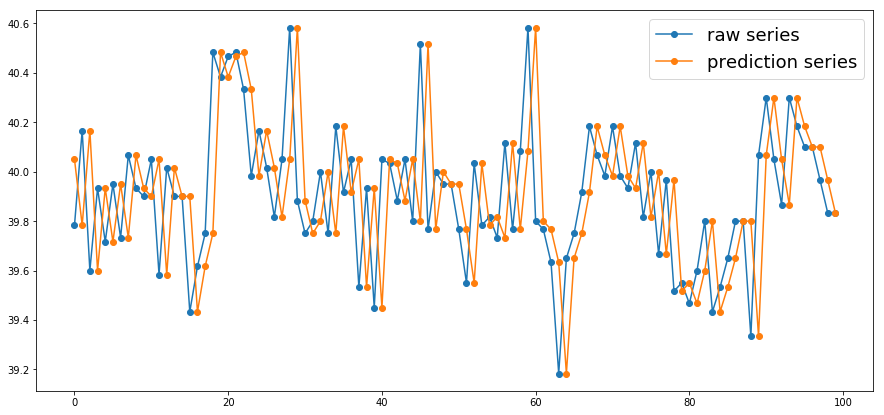

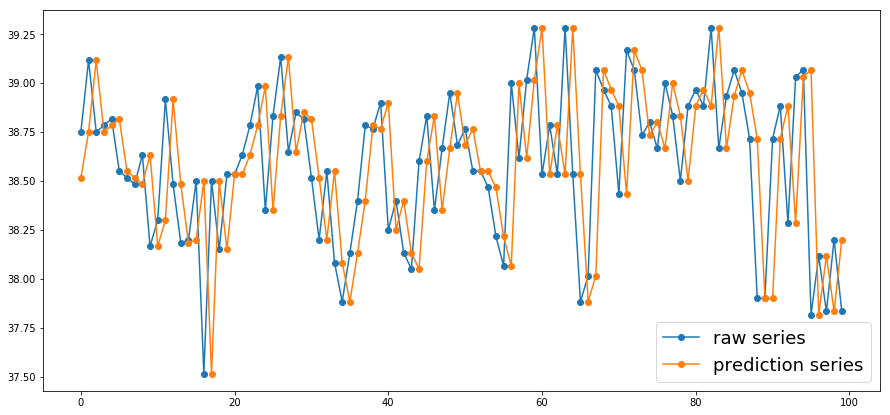

In [5]:
base_prediction = raw_values
real_values = raw_values[1:]

print('TRAIN RMSE: %.3f' % compute_rmse(real_values[:n_train-1], base_prediction[:n_train-1]))
print('TEST RMSE: %.3f' % compute_rmse(real_values[n_train-1:n_train+n_test], base_prediction[n_train-1:n_train+n_test]))

print_series(real_values,base_prediction,100,200)
print_series(real_values,base_prediction,n_train,n_train+100)

## 2. LSTM Model

### 2.1 Train LSTM Model

In [6]:
# fit the model
lstm_model, train_err_hist, test_err_hist = fit_lstm(train_normalized, 1, 3, 20, raw_normalized, scaler)

Epoch 1/1
15768/15768 [==============================] - 38s 2ms/step - loss: 0.0068
Epoch 1/1
15768/15768 [==============================] - 37s 2ms/step - loss: 0.0066
Epoch 1/1
15768/15768 [==============================] - 37s 2ms/step - loss: 0.0065


Train and Test Error History

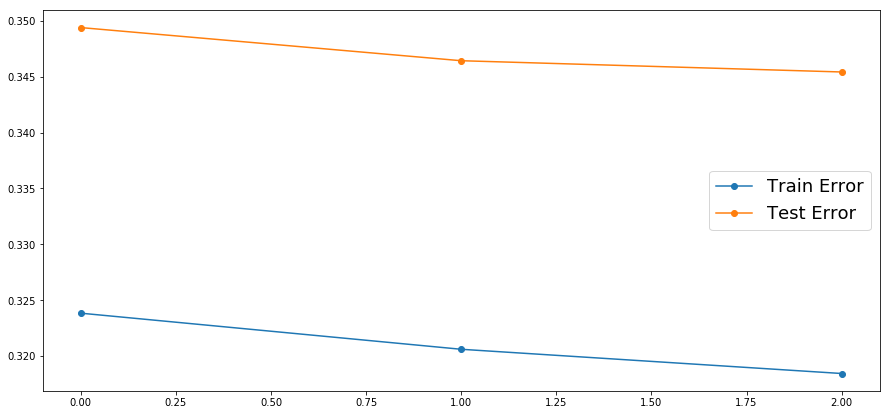

In [7]:
print_series(train_err_hist,test_err_hist,legend_1 = 'Train Error', legend_2 = 'Test Error')

### 2.2 Save & Load Model

Save Model

In [8]:
save_model(lstm_model, model_name = APPLIANCE+"_model_"+VERSION)
save_scaler(scaler, scaler_name = APPLIANCE+"_scaler")
save_ndarray(raw_normalized, APPLIANCE+"_raw_normalized")
save_ndarray(raw_values[:n_train+1],  APPLIANCE+"_train_values")
save_ndarray(train_normalized,  APPLIANCE+"_train_normalized")

Load Model

In [9]:
lstm_model = load_model(model_name = APPLIANCE+"_model_"+VERSION)
scaler = load_scaler(scaler_name = APPLIANCE+"_scaler")
raw_normalized = load_ndarray(ndarray_name = APPLIANCE+"_raw_normalized")

Loaded model from disk


### 2.3 Final Train & Test Performance

Hint: *raw_normalized has 2 columns: 
1. 0 - N-1  -> (predicts to) 1 - N
2. 1 - N    -> (predits to) 2 - N+1 (neglected)

for example:
supervised_values 

[0, array([-4.33333333])],
[array([-4.33333333]), array([-20.9])],

0 -> -4.333333

and this first prediction is transition from raw_values[0] to raw_values[1]

#### 2.3.1 All in One Evaluation

Loaded model from disk
TRAIN RMSE: 0.318
TEST RMSE: 0.345


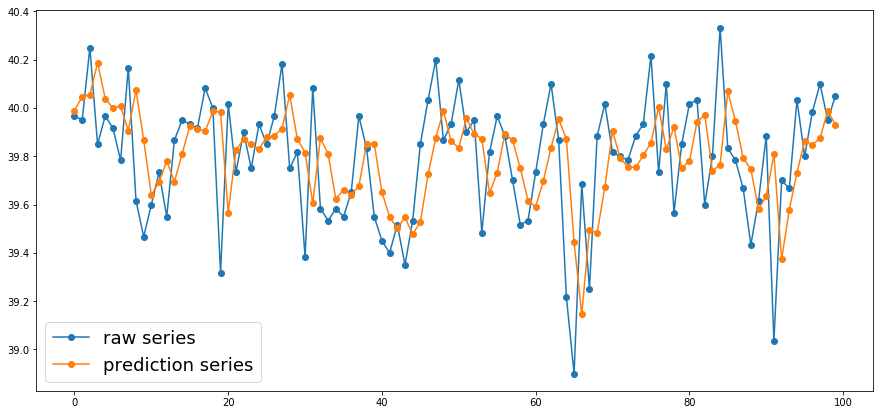

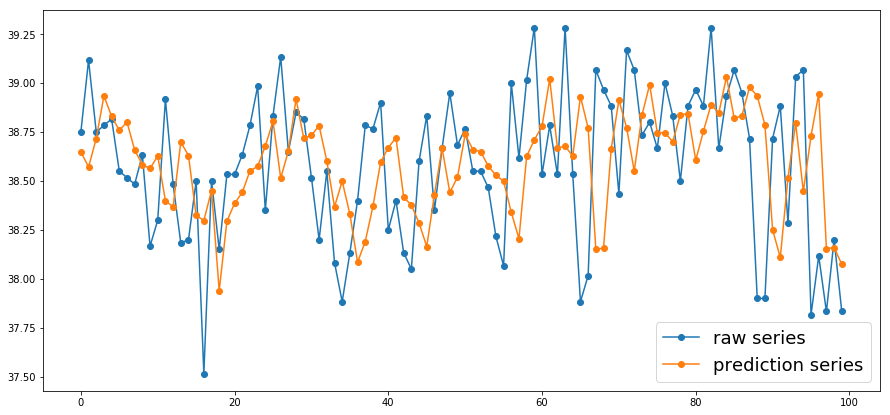

In [10]:
real_values = raw_values[1:]

lstm_model = load_model(model_name = APPLIANCE+"_model_"+VERSION)

raw_normalized_reshaped = raw_normalized[:, 0].reshape(len(raw_normalized), 1, 1)
raw_normalized_predictions = lstm_model.predict(raw_normalized_reshaped, batch_size=1)
lstm_prediction = invert_normalize(scaler, raw_values, raw_normalized_predictions)

print('TRAIN RMSE: %.3f' % compute_rmse(real_values[:n_train], lstm_prediction[:n_train]))
print('TEST RMSE: %.3f' % compute_rmse(real_values[n_train:n_train+n_test], lstm_prediction[n_train:n_train+n_test]))

print_series(real_values[:n_train],lstm_prediction[:n_train],0,100)
print_series(real_values[n_train:n_train+n_test], lstm_prediction[n_train-1:n_train+n_test],0,100)

#### 2.3.2 Train Performance Evaluation 

Loaded model from disk
TRAIN RMSE: 0.318


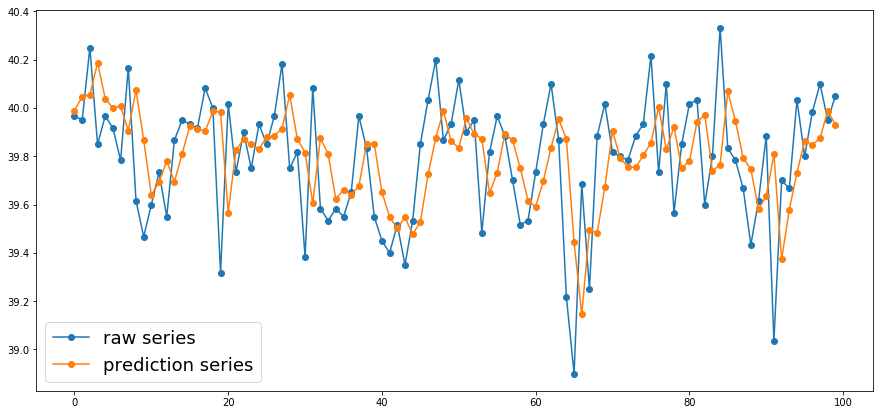

In [11]:
lstm_model = load_model(model_name = APPLIANCE+"_model_"+VERSION)

train_normalized_reshaped = train_normalized[:, 0].reshape(len(train_normalized), 1, 1)
train_normalized_predictions = lstm_model.predict(train_normalized_reshaped, batch_size=1)
lstm_prediction = invert_normalize(scaler, raw_values[:n_train], train_normalized_predictions[:n_train])

print('TRAIN RMSE: %.3f' % compute_rmse(real_values[:n_train], lstm_prediction[:n_train]))
print_series(real_values[:n_train],lstm_prediction[:n_train],0,100)

#save_model(lstm_model,model_name = "FGE_model_1_train_state")


#### 2.3.3 Test Performance Evaluation

Note that the model is not loaded here because we use the state generated by evaluation the training performance

TEST RMSE: 0.345


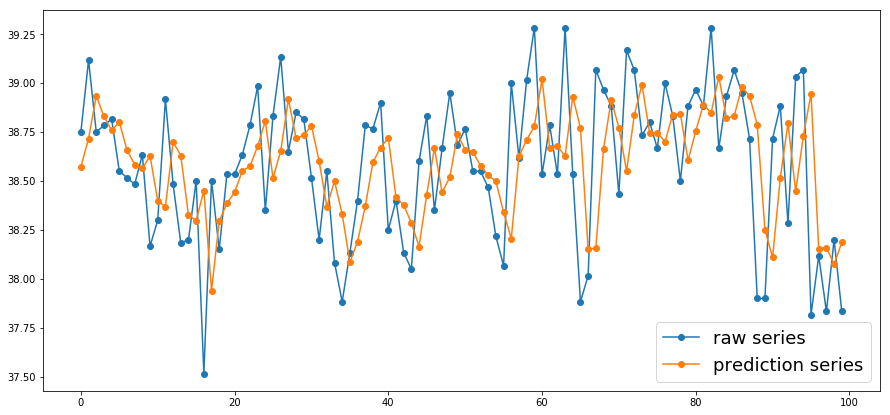

In [12]:
test_normalized_reshaped = test_normalized[:, 0].reshape(len(test_normalized), 1, 1)
test_normalized_predictions = lstm_model.predict(test_normalized_reshaped, batch_size=1)
lstm_prediction = invert_normalize(scaler, raw_values[n_train:], test_normalized_predictions)

print('TEST RMSE: %.3f' % compute_rmse(real_values[n_train:], lstm_prediction))
print_series(real_values[n_train:-1],lstm_prediction[:-1],0,100)

#### 2.3.4 Test Performance Online Evaluation 

Loaded model from disk
Test RMSE: 0.345


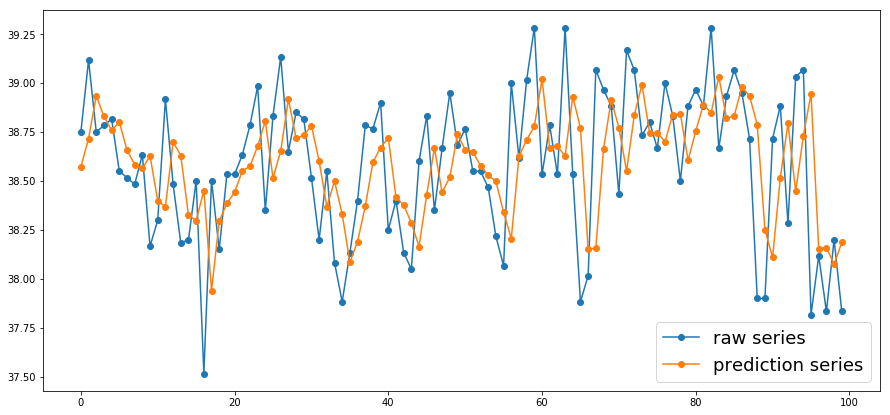

In [13]:
lstm_model = load_model(model_name = APPLIANCE+"_model_" +VERSION)

train_normalized_reshaped = train_normalized[:, 0].reshape(len(train_normalized), 1, 1)
train_normalized_predictions = lstm_model.predict(train_normalized_reshaped, batch_size=1)

result = []
raw = raw_values[(n_train-1):]# np.asarray([[48.9],[ 44.56666667],[ 23.66666667],[ 58.43333333],[ 39.08333333]])
for i in range(len(raw)-1):
    #print(i)
    
    raw_cut = raw[0:i+2]
    diff_input = difference(raw_cut, 1)
    # transform data to be supervised learning
    supervised_input = timeseries_to_supervised(diff_input, 1)
    supervised_input_values = supervised_input.values
    input_normalized = np.concatenate((scaler.transform(supervised_input_values)[:,0], scaler.transform(supervised_input_values)[-1,1]),axis=None)

    #print(input_normalized[-1])
    input_normalized_reshaped = np.asarray([input_normalized[-1]]).reshape(1, 1, 1)
    
    #print(input_normalized_reshaped)
    normalized_predictions = lstm_model.predict(input_normalized_reshaped, batch_size=1)
    #print("step "+  str(i))
    tmp = invert_normalize(scaler, raw_values[n_train+i:], normalized_predictions)
    #print(tmp)
    #if i < 10:
    #    print(input_normalized_reshaped)
    #    print(normalized_predictions)
    #    print(tmp)
    #    print("<<<<<<<<<<<<<<<<<<<<<<")
    result.append(tmp[-1])
    
print('Test RMSE: %.3f' % compute_rmse(real_values[n_train:], result[:-1]))
print_series(real_values[n_train:],result,0,100)

In [14]:
raw_values[n_train-2:n_train+1]

array([[38.96666667],
       [38.45      ],
       [38.51666667]])

In [15]:
raw_values[n_train:n_train+5]

array([[38.51666667],
       [38.75      ],
       [39.11666667],
       [38.75      ],
       [38.78333333]])

In [16]:
electricity_data.iloc[n_train:n_train+10,:]

,EQE
UNIX_TS,
2014-01-18 07,38.516667
2014-01-18 08,38.750000
2014-01-18 09,39.116667
2014-01-18 10,38.750000
2014-01-18 11,38.783333
2014-01-18 12,38.816667
2014-01-18 13,38.550000
2014-01-18 14,38.516667
2014-01-18 15,38.483333


In [17]:
test


array([[array([0.06666667]), array([0.23333333])],
       [array([0.23333333]), array([0.36666667])],
       [array([0.36666667]), array([-0.36666667])],
       ...,
       [array([0.43333333]), array([0.2])],
       [array([0.2]), array([0.1])],
       [array([0.1]), array([0.11666667])]], dtype=object)